In [11]:
import cryptocompare
import quandl
import requests
import pandas as pd


# 2. Time Series and GD with Python and NumPy

In [13]:
quandl.ApiConfig.api_key = 'A-MuwNged3JaKQyLaG7L'
ETH= quandl.get('BITFINEX/ETHUSD', returns= "pandas")
ETH.index = pd.to_datetime(ETH.index)
ETH_data= ETH.loc['2020-01-01':'2024-01-01']

In [14]:
xt = ETH_data['Last']
print(xt)

Date
2020-01-01     130.88
2020-01-02     127.57
2020-01-03     134.42
2020-01-04     134.57
2020-01-05     135.29
               ...   
2023-12-28    2353.80
2023-12-29    2286.50
2023-12-30    2296.90
2023-12-31    2286.60
2024-01-01    2334.50
Name: Last, Length: 1460, dtype: float64


In [2]:
import requests
from datetime import datetime

CryptoCompare_API_KEY = '097b2c463511458171d4d8eaf924f04837a2a62558fc4ff2167f8a3ca8329be7'
url = f"https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=2000&api_key={CryptoCompare_API_KEY}"
response = requests.get(url)
btc_data = response.json()

start_date = datetime.strptime('2020-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-01-01', '%Y-%m-%d')

yt1 = []  # An empty list to store data 

for data in btc_data['Data']['Data']:
    timestamp = data['time']
    date = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')
    close_price = data['close']
    if start_date <= datetime.utcfromtimestamp(timestamp) <= end_date:
         yt1.append(data['close'])


In [17]:
import pandas as pd

# Convert yt to a DataFrame
yt = pd.DataFrame(yt1, columns=['Close Price'])

print(yt)

      Close Price
0         7189.94
1         6965.72
2         7339.70
3         7357.50
4         7359.96
...           ...
1457     42588.94
1458     42073.59
1459     42146.03
1460     42280.14
1461     44197.61

[1462 rows x 1 columns]


In [18]:
yt = yt[:len(xt)] # Ensures that they are of the same length  

In [19]:
print(len(xt))
print(len(yt))

1460
1460


In [20]:
print(type(xt))   # Prints the data type 
print(type(yt))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [21]:
yt = yt.values.flatten() # Coverting yt to one dimensional array

# Analytically from standard OLS formulae

In [22]:
import numpy as np

# OLS calculation
x_bar = np.mean(xt)
y_bar = np.mean(yt)

beta = np.sum((xt - x_bar) * (yt - y_bar)) / np.sum((xt - x_bar) ** 2)
alpha = y_bar - beta * x_bar

print("Alpha (Intercept):", alpha)
print("Beta (Coefficient):", beta)


Alpha (Intercept): 8011.74351699074
Beta (Coefficient): 12.145286343813693


# By trial and error Machine Learning with a Gradient Descent (GD) Algorithm

In [23]:
import numpy as np

# Initializing Parameters
alpha = 0  # Initial guess for alpha
beta = 0   # Initial guess for beta

# Defining Cost Function (Mean Squared Error)
def mse_cost(x, y, alpha, beta):
    n = len(x)
    predictions = alpha + beta * x
    error = predictions - y
    return np.sum(error ** 2) / n

# Gradient Descent Algorithm
def gradient_descent(x, y, alpha, beta, learning_rate, num_iterations):
    n = len(x)
    for i in range(num_iterations):
        predictions = alpha + beta * x
        error = predictions - y
        alpha_gradient = (2 / n) * np.sum(error)
        beta_gradient = (2 / n) * np.sum(error * x)
        alpha -= learning_rate * alpha_gradient
        beta -= learning_rate * beta_gradient
        cost = mse_cost(x, y, alpha, beta)
        if i % 100 == 0:
            print(f"Iteration {i}: Cost = {cost}, alpha = {alpha}, beta = {beta}")
    return alpha, beta

# Printing results 
alpha, beta = gradient_descent(xt, yt, alpha, beta, learning_rate=0.0001, num_iterations=400)
print("Final alpha:", alpha)
print("Final beta:", beta)


Iteration 0: Cost = 694361896037178.4, alpha = 5.775363569863014, beta = 12904.868431183557
Iteration 100: Cost = inf, alpha = 7.708562795321137e+292, beta = 1.8753376210292387e+296
Iteration 200: Cost = 0.0, alpha = -inf, beta = nan
Iteration 300: Cost = 0.0, alpha = -inf, beta = nan
Final alpha: -inf
Final beta: nan


/var/folders/g4/z967cn3s5gj8r82tg6f0lkgm0000gn/T/ipykernel_35856/3767706177.py:23: RuntimeWarning: invalid value encountered in scalar subtract
  beta -= learning_rate * beta_gradient


The ouput suggests a a convergence error during the optimization process. Convergence to a Loss Function minimum may be difficult to obtain in practice becasue loss function in real life are non-convex, this means they contain more than one local minima and saddle points, this makes it hard for the optimization process to compute the global minimum. 

The real world data is typlically noisy, this can lead to erratic convergence. 
The selection of learning rate can also distort the results, becasue a too high learing rate can cause divergence, while a very low rate leads to slow convergence.

To overcome the stated challenges, we can utilize Stochastic Gradient Descent (SGD) to 
introducing randomness and exploration, this can help escape local minima 

Using mini-batch gradient descent and momentum can help stabilize the optimization process by averaging gradient over small samples and incorporating past gradients.

Techniques like adaptive learning rates such as AdaGrad or Adam, and early stopping can help fine-tune the learning rate during training.


# 4 Time Series Forecasting

I have Bitcoin price series(Dependant Variable) from Quandl,from January 1, 2018, to January 1, 2024.

I have included three factors that potentially influencing Bitcoin's price as my independent vatiables; 

1. Trading volume : Reflects the level of market activity(buy/sell orders) and liquidity in Bitcoin markets, this will indicate the investors confidence in Bitcoin and can impact its price.

2. Mining difficulty : Reflect the time it takes to mine new blocks in bitcoin, therefore directly impacts the supply of Bitcoin, potentially impacting price.

3. Total Bitcoin supply: Supply of Bitcoin in circulation influences its scarcity, inflation rates, and impacts the long-term price expectations among investors

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import quandl

# Retrieve Bitcoin data from Quandl
bitcoin_price_data = quandl.get("BCHAIN/MKPRU", start_date="2018-01-01", end_date="2024-01-01")
bitcoin_volume_data = quandl.get("BCHAIN/MWTRV", start_date="2018-01-01", end_date="2024-01-01")
bitcoin_difficulty = quandl.get("BCHAIN/DIFF", start_date="2018-01-01", end_date="2024-01-01")
total_bitcoins = quandl.get("BCHAIN/TOTBC", start_date="2018-01-01", end_date="2024-01-01")

bitcoin_data = pd.concat([bitcoin_price_data, bitcoin_volume_data,bitcoin_difficulty,total_bitcoins], axis=1)
bitcoin_data.columns = ['Price', 'Volume', 'Difficulty', 'Total_BTC']

bitcoin_data.dropna(inplace=True)

# Display the first few rows of the combined data
print(bitcoin_data.head())


                   Price        Volume    Difficulty   Total_BTC
Date                                                            
2018-01-01  13796.000000  64570.534994  1.922581e+12  16774887.5
2018-01-02  15005.856667  55603.799596  1.931136e+12  16778587.5
2018-01-03  15053.261667  63696.642580  1.931136e+12  16780450.0
2018-01-04  15039.240000  74606.126855  1.931136e+12  16782650.0
2018-01-05  17174.120000  70424.576013  1.931136e+12  16784437.5


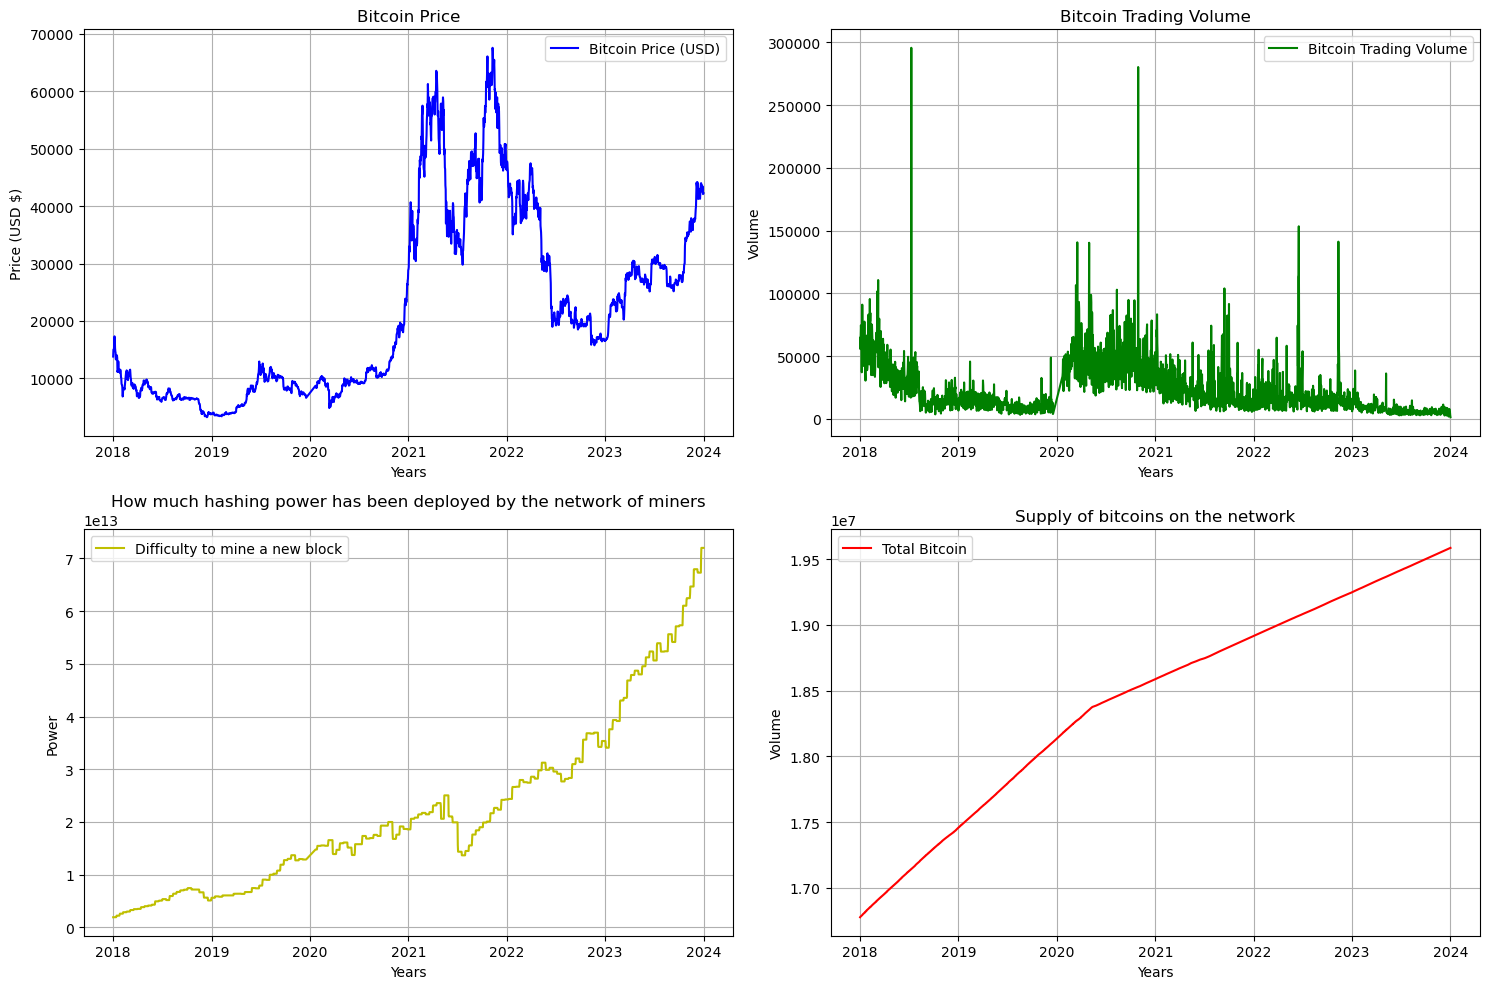

In [82]:
import matplotlib.pyplot as plt

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Ploting Bitcoin price and trading volume
axs[0, 0].plot(bitcoin_data.index, bitcoin_data['Price'], color='b', label='Bitcoin Price (USD)')
axs[0, 0].set_xlabel('Years')
axs[0, 0].set_ylabel('Price (USD $)')
axs[0, 0].set_title('Bitcoin Price')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(bitcoin_data.index, bitcoin_data['Volume'], color='g', label='Bitcoin Trading Volume')
axs[0, 1].set_xlabel('Years')
axs[0, 1].set_ylabel('Volume')
axs[0, 1].set_title('Bitcoin Trading Volume')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Ploting Difficulty to mine a new block and Total Bitcoin supply
axs[1, 0].plot(bitcoin_data.index, bitcoin_data['Difficulty'], color='y', label='Difficulty to mine a new block')
axs[1, 0].set_xlabel('Years')
axs[1, 0].set_ylabel('Power')
axs[1, 0].set_title('How much hashing power has been deployed by the network of miners')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(bitcoin_data.index, bitcoin_data['Total_BTC'], color='r', label='Total Bitcoin')
axs[1, 1].set_xlabel('Years')
axs[1, 1].set_ylabel('Volume')
axs[1, 1].set_title('Supply of bitcoins on the network')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

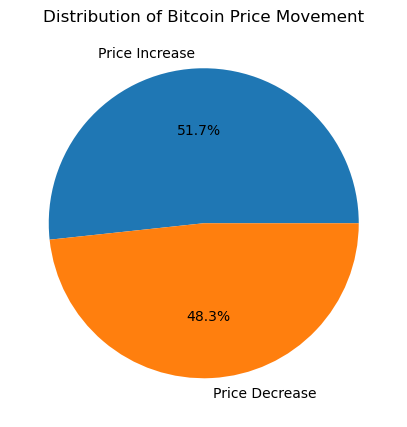

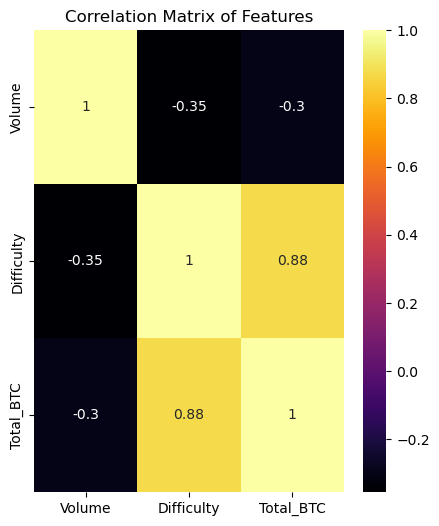

In [133]:
# Defining features and target variable
features = bitcoin_data[['Volume', 'Difficulty', 'Total_BTC']]
target = bitcoin_data['Price']

# Converting continuous target variable into categorical
target_category = pd.cut(target.diff(), bins=[float('-inf'), 0, float('inf')], labels=['Price Decrease', 'Price Increase'])

# Visualizing the distribution of the target variable using a pie chart
plt.figure(figsize=(5, 6))
plt.pie(target_category.value_counts(), labels=['Price Increase', 'Price Decrease'], autopct='%1.1f%%')
plt.title('Distribution of Bitcoin Price Movement')
plt.show()

# Visualizing the correlation matrix of the features using a heatmap
plt.figure(figsize=(5, 6))
sns.heatmap(features.corr(), annot=True, cmap='inferno')
plt.title('Correlation Matrix of Features')
plt.show()


The correlation matrix helps identify the linear relationship between different features in the dataset, to identify which features have a strong positive(+) or negative correlation(-) with the target variable. 

The pie chart illustrates the distribution of movement of Bitcoin price (increase or decrease).It provides a clear visual representation of the balance between price increases and decreases in the dataset.

In [128]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# Assuming bitcoin_data is a DataFrame containing your data

X = bitcoin_data[['Volume', 'Difficulty', 'Total_BTC']]
y = bitcoin_data['Price']

# Spliting the Data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Regression Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regression': RandomForestRegressor()
}

# Training the Models
for name, model in models.items():
    model.fit(X_train, y_train)

# Evaluating the Models
for name, model in models.items():
    y_pred = model.predict(X_valid)
    r2 = r2_score(y_valid, y_pred)
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    print(f'{name}: R-squared = {r2:.4f}, RMSE = {rmse:.2f}')


Linear Regression: R-squared = 0.4187, RMSE = 12569.31
Random Forest Regression: R-squared = 0.9968, RMSE = 926.36


The R square value of Random Forest Regression is very close to 1, indicating  very high level of predictive capability compared to the linear regression model
as regression model explains approximately 99.68% of the variance. The RMSE value of Random is substantially lower (926.36) than the linera model, indicating a much smaller average deviation from the actual values.   
This suggests that Random Forest Regression model outperforms the Linear Regression model in terms of both R-squared value and RMSE. 

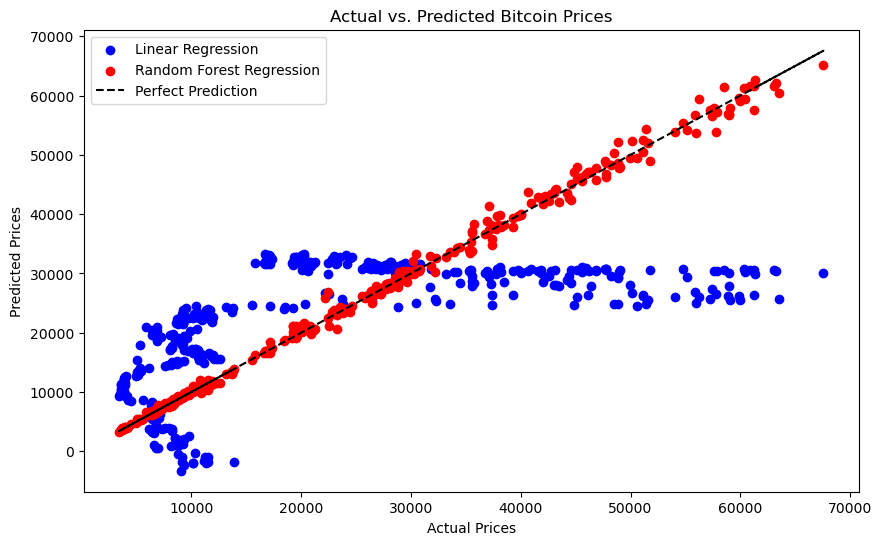

In [132]:
import matplotlib.pyplot as plt

# Predicting on validation data
y_pred_linear = models['Linear Regression'].predict(X_valid)
y_pred_rf = models['Random Forest Regression'].predict(X_valid)

# Plotting actual vs. predicted for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred_linear, color='blue', label='Linear Regression')

# Plotting actual vs. predicted for Random Forest Regression
plt.scatter(y_valid, y_pred_rf, color='red', label='Random Forest Regression')

# Plotting the line of perfect prediction
plt.plot(y_valid, y_valid, color='black', linestyle='--', label='Perfect Prediction')

plt.title('Actual vs. Predicted Bitcoin Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()


Random Forest Regression allwed me to explore the nonlinear relationships and interactions between the predictors and Bitcoin's price, which were not captured by linear regression. It was a more robust assesment tool because it was able to handle large number of complex input variables to compute relationships between the predictors (volume, difficulty, total BTC) and Bitcoin's price.